Необходимо выяснить те факторы, которые определяют успешность игры. Для нашего исследования доступны следующие переменные:

- платформа
- год издания
- жанр
- выручка игры по регионам мира: Сервеная Америка, Европа, Япония, остальные регионы
- оценка критиков
- оценка пользователей
- рейтинг игры

Необходимо ответить на вопросы:

- Сколько игр выпускалось в разные годы? Влияет ли количество игр на уровень продаж?
- Какая динамика продаж по платформам?
- Какой временной период можно считать "актуальным"?
- Какие платформы дают наибольший уровень продаж за "актуальный" период?
- Как влияют на продажи оценки пользователей и критиков?
- Как влияет на продажи жанр игры?

- Какие платформы наиболее прибыльны в каждом из регионов?
- Какие жанры наиболее прибыльны в каждом из регионов?
- Как влияет рейтинг на уровень продаж?

- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые?
- Средние пользовательские рейтинги жанров Action и Sports одинаковые?

Как мы на это будем отвечать:

1. Изучим все данные и попытаемсы понять, чем и как они могут быть полезны при ответе на наши вопросы
2. Изучим динамику продаж по различным платформам и жанрам. Посмотрим как рейтинг влияет на продажи
3. Сравним динамику продаж по различным региноам (в разбивке по жанрам, платформам и т.д.)
4. Ответим на вопрос, чем и как отличаются различные регионы, включая влияние рейтингов
5. Определим степень достоверности пары гипотез из предыдущего пункта
6. Сделаем общие выводы

# 1. Стартуем

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

In [139]:
sns.set()

In [140]:
data = pd.read_csv('/datasets/games.csv')

Одним блоком введём все функции, которые пригодятся в этой работе, но были уже использованы в предыдущих проектах.

In [141]:
'''
Напишем функцию, которая будет показывать подробную информацию о содержании переменной column: 
Сколько имеется пропущенных значений, и какой они составляют процент от общего количества строк. 
Также функция будет выдавать для количественных переменных "минамальное", "максимальное", "среднее", "медианное" значения,
строить гистраграмму, а для категориальной переменной показывать количество строк в каждой из категорий.

data - исследуемый DataFrame
column - исследуемач переменная
quantitative - в позиции False означает категориальную переменную, а позиции True - количественную
'''

def column_info(data, column, quantitative=False, mean=True, median=True, hist=True, bins=50):    
    lost = data[column].isna().sum() #смотрим количество пропусков
    total = data.shape[0] #длина всех значений переменной
    print()
    print('*** Информация по столбцу {} ***'.format(column))
    print()
    print('Тип данных столбца {}: {}:'.format(column, data[column].dtype))
    print('В столбце {} пропущено {} из {} строк, что составляет {:.2%}'
          .format(column, lost, total, lost / total)) #считаем процент пропусков
    if quantitative:        
        print('Минимальное значение: {:.2f}'.format(data[column].min()))
        print('Максимальное значение: {:.2f}'.format(data[column].max()))
        if mean:
            print('Среднее значение: {:.2f}'.format(data[column].mean()))
        if median:
            print('Медианное значение: {:.2f}'.format(data[column].median()))
        if hist:
            gridsize = (5, 1)
            fig = plt.figure(figsize=(15, 5))
            ax1 = plt.subplot2grid(gridsize, (0, 0))
            ax2 = plt.subplot2grid(gridsize, (1, 0), rowspan=4)                       
            sns.boxplot(data[column], ax=ax1)            
            sns.distplot(data[column], kde=False, bins=bins, ax=ax2)            
            ax1.get_xaxis().set_visible(False)            
            plt.show()                        
    else:
        print()
        print('Количество значений в каждой из категорий:')
        print(data[column].value_counts())        
    print()    

def trimmer(data, column):    
    _, bp = pd.DataFrame.boxplot(data[column], return_type='both')
    whiskers = [whiskers.get_ydata() for whiskers in bp["whiskers"]] 
    left_boundary = whiskers[0][1]
    right_boundary = whiskers[1][1]        
        
    data.loc[data[column] < left_boundary, column] = left_boundary
    data.loc[data[column] > right_boundary, column] = right_boundary
    plt.close('all')

def pirson_print(data, column1, column2):
    print('Коэффициент корреляции между {} и {}: {:.2f}'
          .format(column1, column2, data[column1].corr(data[column2])))

In [142]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Здесь любят, чтобы названия столбцов содержали только строчные буквы. Я тоже люблю.

In [143]:
data.columns = [i.lower() for i in data.columns]

In [144]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Данные как данные, в общем, напоминают прежние, только большое количество NaN их немного портит.

In [145]:
data.duplicated().sum()

0

Дубликаты есть? Не нашёл.

### Столбец `name`

In [146]:
column_info(data, 'name')


*** Информация по столбцу name ***

Тип данных столбца name: object:
В столбце name пропущено 2 из 16715 строк, что составляет 0.01%

Количество значений в каждой из категорий:
Need for Speed: Most Wanted           12
Madden NFL 07                          9
Ratatouille                            9
LEGO Marvel Super Heroes               9
FIFA 14                                9
                                      ..
Derby Stallion 04                      1
The Sims 2: Family Fun Stuff           1
Agatha Christie: Death on the Nile     1
Imagine: Party Babyz                   1
Pokken Tournament                      1
Name: name, Length: 11559, dtype: int64



Пропущенных данных почти нет. Что-то игр с названием "Need for Speed: Most Wanted" многовато. Я ещё готов поверить в 9 платформ, но 12 - уже перебор.

In [147]:
data[data['name']=='LEGO Marvel Super Heroes']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
730,LEGO Marvel Super Heroes,X360,2013.0,Action,1.24,0.79,0.00,0.19,80.0,7.6,E10+
945,LEGO Marvel Super Heroes,PS3,2013.0,Action,0.77,0.76,0.01,0.29,82.0,7.9,E10+
1139,LEGO Marvel Super Heroes,PS4,2013.0,Action,0.59,0.76,0.01,0.26,83.0,7.7,E10+
1959,LEGO Marvel Super Heroes,XOne,2013.0,Action,0.61,0.35,0.00,0.09,NaN,6.8,E10+
2313,LEGO Marvel Super Heroes,3DS,2013.0,Action,0.42,0.36,0.04,0.07,61.0,5.2,E10+
2778,LEGO Marvel Super Heroes,WiiU,2013.0,Action,0.31,0.35,0.02,0.06,82.0,8,E10+
3876,LEGO Marvel Super Heroes,PSV,2013.0,Action,0.11,0.29,0.00,0.11,NaN,NaN,NaN
5054,LEGO Marvel Super Heroes,DS,2013.0,Action,0.22,0.13,0.00,0.03,NaN,4.8,E10+
8369,LEGO Marvel Super Heroes,PC,2013.0,Action,0.04,0.12,0.00,0.01,78.0,8.1,E10+


In [148]:
data[data['name']=='Need for Speed: Most Wanted']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
253,Need for Speed: Most Wanted,PS2,2005.0,Racing,2.03,1.79,0.08,0.47,82.0,9.1,T
523,Need for Speed: Most Wanted,PS3,2012.0,Racing,0.71,1.46,0.06,0.58,NaN,NaN,NaN
1190,Need for Speed: Most Wanted,X360,2012.0,Racing,0.62,0.78,0.01,0.15,83.0,8.5,T
1591,Need for Speed: Most Wanted,X360,2005.0,Racing,1.00,0.13,0.02,0.10,83.0,8.5,T
1998,Need for Speed: Most Wanted,XB,2005.0,Racing,0.53,0.46,0.00,0.05,83.0,8.8,T
2048,Need for Speed: Most Wanted,PSV,2012.0,Racing,0.33,0.45,0.01,0.22,NaN,NaN,NaN
3581,Need for Speed: Most Wanted,GC,2005.0,Racing,0.43,0.11,0.00,0.02,80.0,9.1,T
5972,Need for Speed: Most Wanted,PC,2005.0,Racing,0.02,0.23,0.00,0.04,82.0,8.5,T
6273,Need for Speed: Most Wanted,WiiU,2013.0,Racing,0.13,0.12,0.00,0.02,NaN,NaN,NaN
6410,Need for Speed: Most Wanted,DS,2005.0,Racing,0.24,0.01,0.00,0.02,45.0,6.1,E


Нет, вполне такое может быть. Оказывается игры с одним и тем же названием выпускаются в разные годы на рызных платформах, вот и результат.

**Вывод** Откровенно говоря, столбец 'name' мало интересен. Можно его удалить, никак не повлияет на конечные выводы.

**Важно** Может ли одна и та же игра выходить на разных платформах в разные годы? Может, примеров сколько угодно, например, GTAV. Могут ли быть разные игры с одним названием - могут, только что убедились. Могут ли пользователи одной игре ствить разные оценки? Примеров неудачных портов на ПК хоть отбавляй. Поэтому не будем фантазировать, а отталкиваться от реальных данных. Пропуски же заполнять только при острой нужде (например, когда обязательно нужен будет тип данных `int` или применение статистических методов.

### Столбец `platform`

In [149]:
column_info(data, 'platform')


*** Информация по столбцу platform ***

Тип данных столбца platform: object:
В столбце platform пропущено 0 из 16715 строк, что составляет 0.00%

Количество значений в каждой из категорий:
PS2     2161
DS      2151
PS3     1331
Wii     1320
X360    1262
PSP     1209
PS      1197
PC       974
XB       824
GBA      822
GC       556
3DS      520
PSV      430
PS4      392
N64      319
XOne     247
SNES     239
SAT      173
WiiU     147
2600     133
GB        98
NES       98
DC        52
GEN       29
NG        12
SCD        6
WS         6
3DO        3
TG16       2
GG         1
PCFX       1
Name: platform, dtype: int64



Олично, пропусков нет в важном столбце. Платформ насочиняли за 35 лет много, но некоторые совсем непопулярные.

### Столбец `year_of_release`


*** Информация по столбцу year_of_release ***

Тип данных столбца year_of_release: float64:
В столбце year_of_release пропущено 269 из 16715 строк, что составляет 1.61%
Минимальное значение: 1980.00
Максимальное значение: 2016.00


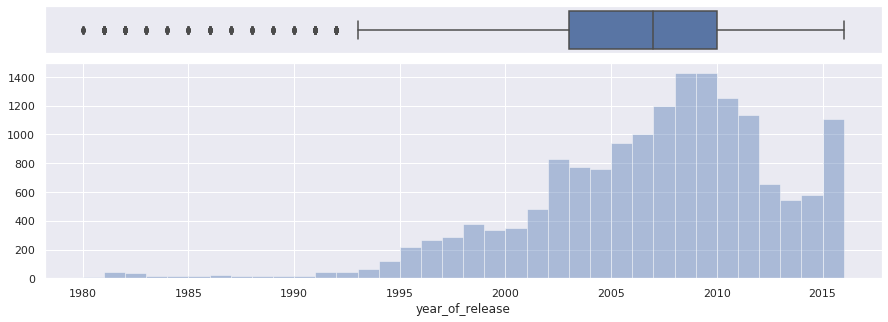

In [150]:
column_info(data, 'year_of_release', quantitative=True, mean=False, median=False, hist=True, bins=36)

**!Важно** Мы не будем заполнять пропущенные значения ради заполнения, без крайней необходимости, так как при этом искажаются данные. Если же такая крайняя необходимость на каком-либо этапе возникнет, то это будет отдельно оговорено и выполнено.
То же можно сказать про выбрасывание строк с пропуском: с каждым выбрасыванием теряется информация.

*Пока это не мешает - не трогаем.*

Так как в столбце есть `NaN` (а это тип `float`), то перевести его значения в тип `int` не получится. Пусть уж лучше будет `float`, чем заполнять года средним.

### Столбец `genre`

In [151]:
column_info(data, 'genre')


*** Информация по столбцу genre ***

Тип данных столбца genre: object:
В столбце genre пропущено 2 из 16715 строк, что составляет 0.01%

Количество значений в каждой из категорий:
Action          3369
Sports          2348
Misc            1750
Role-Playing    1498
Shooter         1323
Adventure       1303
Racing          1249
Platform         888
Simulation       873
Fighting         849
Strategy         683
Puzzle           580
Name: genre, dtype: int64



In [152]:
data[data['genre'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Всё в порядке: информация по платформе есть, по продажам есть - пригодится.

### Столбецы `na_sales`, `eu_sales`, `jp_sales`, `other_sales`


*** Информация по столбцу na_sales ***

Тип данных столбца na_sales: float64:
В столбце na_sales пропущено 0 из 16715 строк, что составляет 0.00%
Минимальное значение: 0.00
Максимальное значение: 41.36
Среднее значение: 0.26
Медианное значение: 0.08


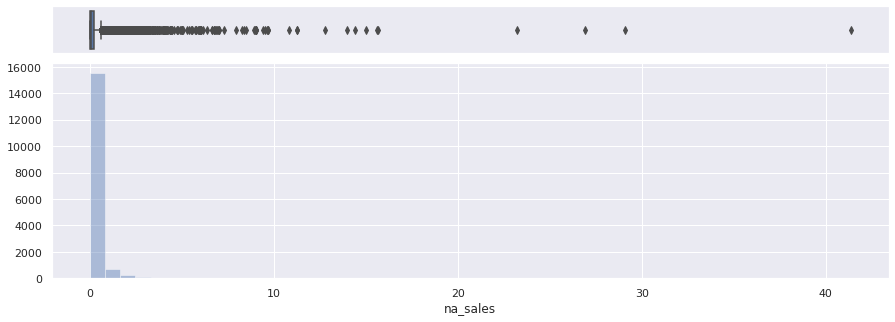

In [153]:
column_info(data, 'na_sales', quantitative=True)

Всё в порядке, выбросы только большие.
Могут ли игры столько стоить? Нужно изучать вопрос отдельно. Для наших же целей воспользуемся функцией, которая обрезает выбросы, для хороших статистических выкладок лучше так и сделать. Описание функции есть выше.

In [154]:
trimmer(data, 'na_sales')


*** Информация по столбцу na_sales ***

Тип данных столбца na_sales: float64:
В столбце na_sales пропущено 0 из 16715 строк, что составляет 0.00%
Минимальное значение: 0.00
Максимальное значение: 0.60
Среднее значение: 0.16
Медианное значение: 0.08


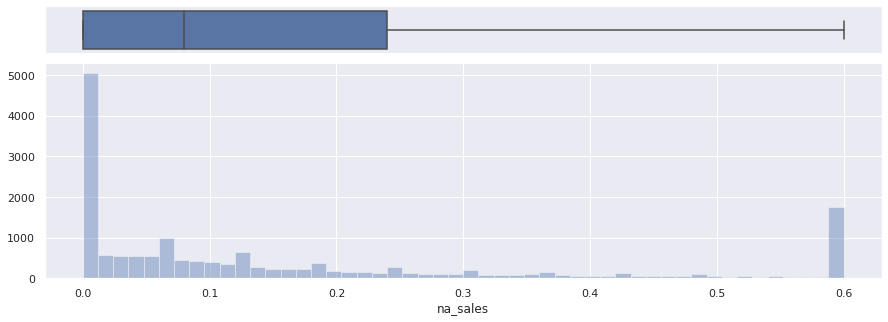

In [155]:
column_info(data, 'na_sales', quantitative=True)

Гораздо лучше. Много 0-х значений. Предположим, что игры - не всегда были прибыльным большим бизнесом  и далеко не все игры выходят в тираж.

Проделаем то же самое с остальными "продажами".


*** Информация по столбцу eu_sales ***

Тип данных столбца eu_sales: float64:
В столбце eu_sales пропущено 0 из 16715 строк, что составляет 0.00%
Минимальное значение: 0.00
Максимальное значение: 28.96
Среднее значение: 0.15
Медианное значение: 0.02


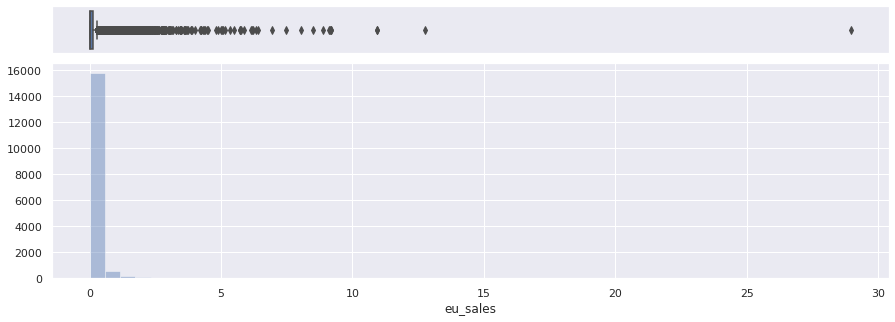

In [156]:
column_info(data, 'eu_sales', quantitative=True)

In [157]:
trimmer(data, 'eu_sales')


*** Информация по столбцу eu_sales ***

Тип данных столбца eu_sales: float64:
В столбце eu_sales пропущено 0 из 16715 строк, что составляет 0.00%
Минимальное значение: 0.00
Максимальное значение: 0.27
Среднее значение: 0.07
Медианное значение: 0.02


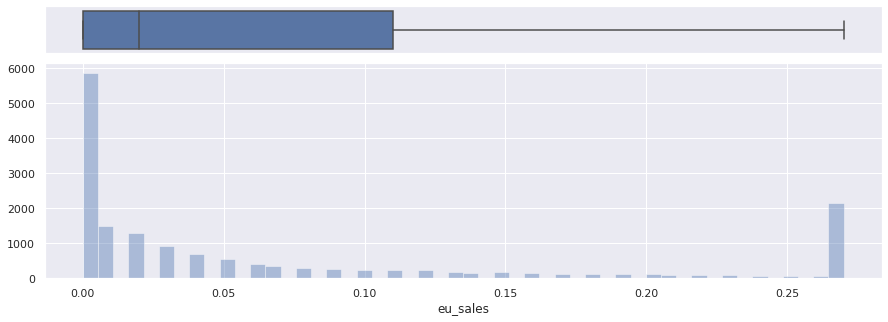

In [158]:
column_info(data, 'eu_sales', quantitative=True)


*** Информация по столбцу jp_sales ***

Тип данных столбца jp_sales: float64:
В столбце jp_sales пропущено 0 из 16715 строк, что составляет 0.00%
Минимальное значение: 0.00
Максимальное значение: 10.22
Среднее значение: 0.08
Медианное значение: 0.00


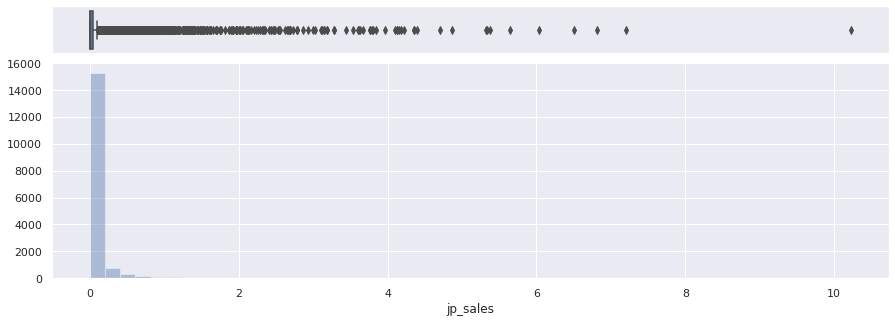

In [159]:
column_info(data, 'jp_sales', quantitative=True)

In [160]:
trimmer(data, 'jp_sales')


*** Информация по столбцу jp_sales ***

Тип данных столбца jp_sales: float64:
В столбце jp_sales пропущено 0 из 16715 строк, что составляет 0.00%
Минимальное значение: 0.00
Максимальное значение: 0.10
Среднее значение: 0.02
Медианное значение: 0.00


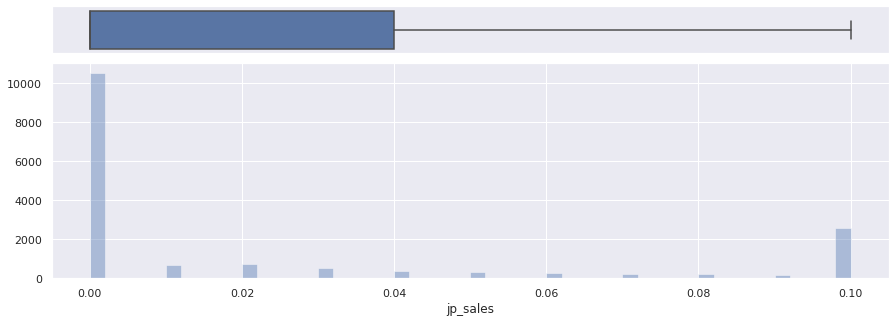

In [161]:
column_info(data, 'jp_sales', quantitative=True)


*** Информация по столбцу other_sales ***

Тип данных столбца other_sales: float64:
В столбце other_sales пропущено 0 из 16715 строк, что составляет 0.00%
Минимальное значение: 0.00
Максимальное значение: 10.57
Среднее значение: 0.05
Медианное значение: 0.01


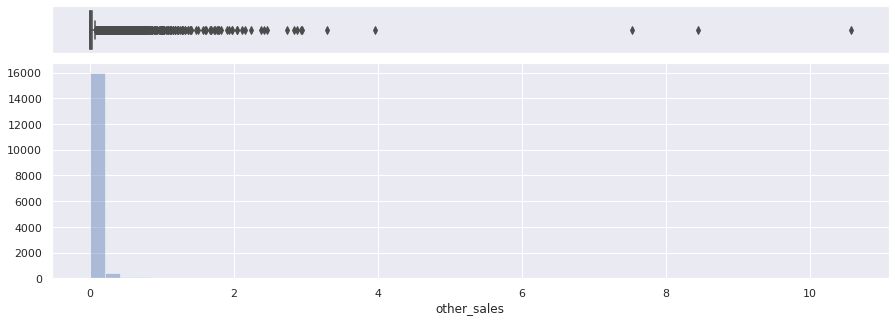

In [162]:
column_info(data, 'other_sales', quantitative=True)

In [163]:
trimmer(data, 'other_sales')


*** Информация по столбцу other_sales ***

Тип данных столбца other_sales: float64:
В столбце other_sales пропущено 0 из 16715 строк, что составляет 0.00%
Минимальное значение: 0.00
Максимальное значение: 0.07
Среднее значение: 0.02
Медианное значение: 0.01


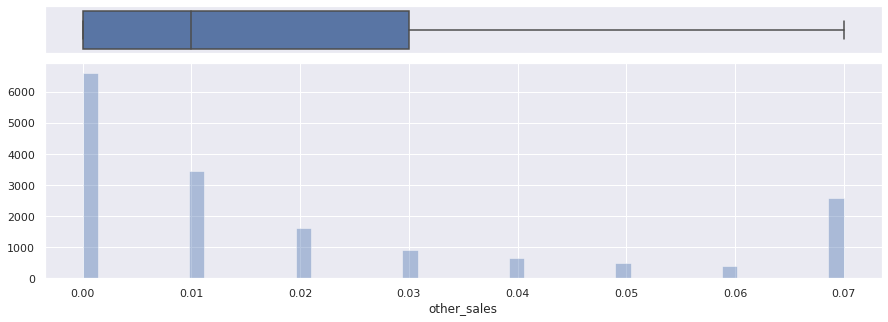

In [164]:
column_info(data, 'other_sales', quantitative=True)

### Столбец `critic_score`


*** Информация по столбцу critic_score ***

Тип данных столбца critic_score: float64:
В столбце critic_score пропущено 8578 из 16715 строк, что составляет 51.32%
Минимальное значение: 13.00
Максимальное значение: 98.00
Среднее значение: 68.97
Медианное значение: 71.00


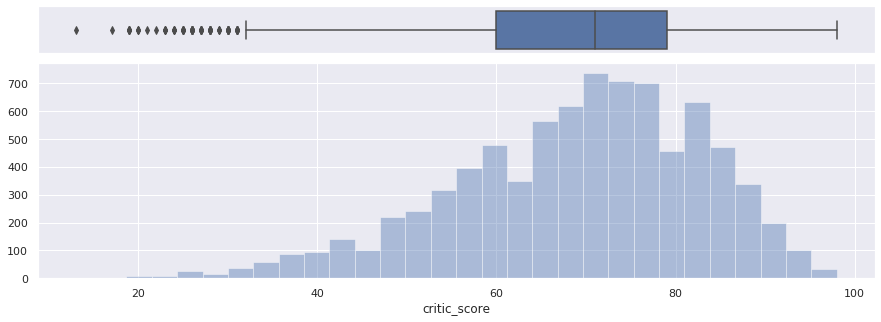

In [165]:
column_info(data, 'critic_score', quantitative=True, bins=30)

TBD - to be determined. То есть рейтинга на данный момент нет, а для нас это `NaN`. Переведём этот столбец в `float` с помощью хитрой фунции `to_float`.

In [166]:
def to_float(value):
    try:
        return float(value)
    except:
        return np.nan

In [167]:
data['user_score'] = data['user_score'].apply(to_float)

Много пропусков. Что же - не каждая игра заслуживает оценок.

### Столбец `user_score`


*** Информация по столбцу user_score ***

Тип данных столбца user_score: float64:
В столбце user_score пропущено 9125 из 16715 строк, что составляет 54.59%
Минимальное значение: 0.00
Максимальное значение: 9.70
Среднее значение: 7.13
Медианное значение: 7.50


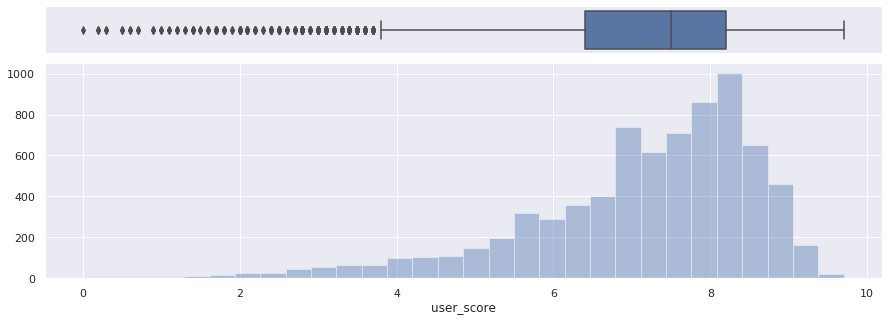

In [168]:
column_info(data, 'user_score', quantitative=True, bins=30)

Пользователи тоже не любят оценивать noname игры.

### Столбец `rating`

In [169]:
data['rating'].fillna('no_rating', inplace=True)

In [170]:
column_info(data, 'rating')


*** Информация по столбцу rating ***

Тип данных столбца rating: object:
В столбце rating пропущено 0 из 16715 строк, что составляет 0.00%

Количество значений в каждой из категорий:
no_rating    6766
E            3990
T            2961
M            1563
E10+         1420
EC              8
RP              3
K-A             3
AO              1
Name: rating, dtype: int64



Пропуски могут быть объяснены теми же причинами: руки не добрались. Некоторые рейтинги вовсе редки, например, AO - Adults Only. Страшно даже смотреть, что же это такое.

Создали столбец с общими продажами по всем регионам.

In [171]:
data['total_sales'] = (data['na_sales'] + data['eu_sales'] + data['jp_sales']
                           + data['other_sales']
                          )

# 2. Исследуем

Посмотрим, сколько игры выпускали по годам.

## По годам

In [172]:
(data
    .pivot_table(index='year_of_release', values='name', aggfunc='count')
    .sort_values(by='name', ascending=False)
    .rename(columns={'name':'count'})
    .head(10)
) 

,count
year_of_release,
2008.0,1427
2009.0,1426
2010.0,1255
2007.0,1197
2011.0,1136
2006.0,1006
2005.0,939
2002.0,829
2003.0,775


Возможные причины: Игры стали более масштабные, на разработку которых стало уходить куда больше ресурсов.
Что более вероятно: Многие разработчики стали больше внимания уделять мобильным платформам, которые здесь не представлены.

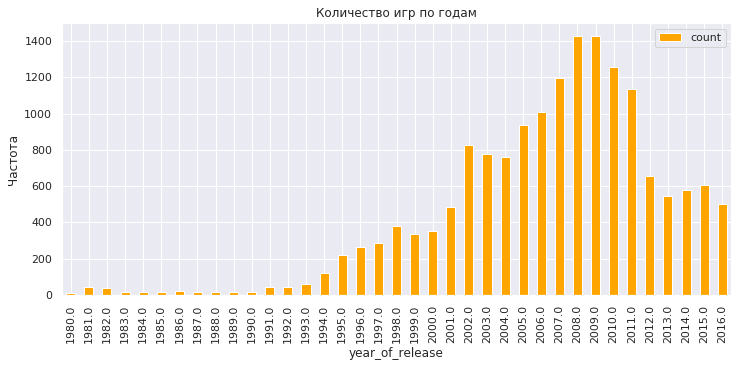

In [173]:
(data
    .pivot_table(index='year_of_release', values='name', aggfunc='count')    
    .rename(columns={'name':'count'})
    .plot(kind='bar', color='orange', figsize=(12,5), grid=True)
)
plt.xlabel('year_of_release')
plt.ylabel('Частота')
plt.title('Количество игр по годам')
plt.show()

Видно, что рассвет игровой индусткии начинается в начале 90-х. А начиная с кризисного 2008 года игр стали делать меньше.

## По платформам

In [174]:
platform_total_sales_data = data.groupby('platform')['total_sales'].sum()
platform_total_sales_data.sort_values(ascending=False).head(10)

platform
PS2     677.63
X360    501.17
PS3     498.39
DS      422.19
Wii     406.56
PS      395.36
GBA     211.28
XB      209.25
PSP     196.25
GC      144.96
Name: total_sales, dtype: float64

**Вывод** Вот они самые прибыльные платформы за всё время. Запишем их в отдельный список `top10_platforms_list`.

In [175]:
top10_platforms_list = (data
    .groupby('platform')['total_sales']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
    .to_list()
)
top10_platforms_list

['PS2', 'X360', 'PS3', 'DS', 'Wii', 'PS', 'GBA', 'XB', 'PSP', 'GC']

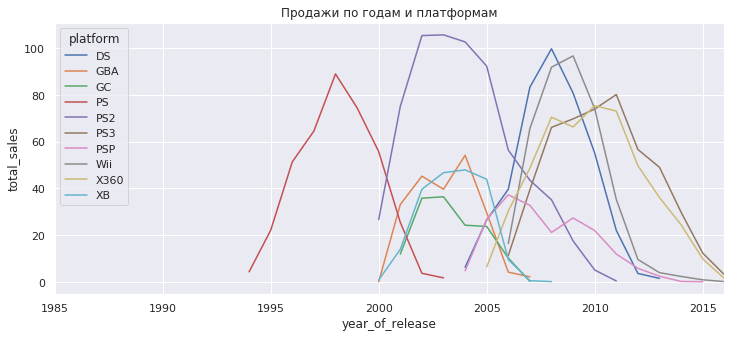

In [176]:
(data[data['platform'].isin(top10_platforms_list)]
    .pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
    .plot(figsize=(12,5), grid=True)
)
plt.ylabel('total_sales')
plt.title('Продажи по годам и платформам')
plt.show()

**Вывод** Здесь можно увидеть жизненный цикл кажой из платформ из Топ-10. PS2 доминировала в середине 0-х, сейчас продажи возглавляет её наследница PS4.

Рассмотрим отдельно семейство консолей PS.

In [177]:
ps_family = ['PS', 'PS2', 'PS3', 'PS4']

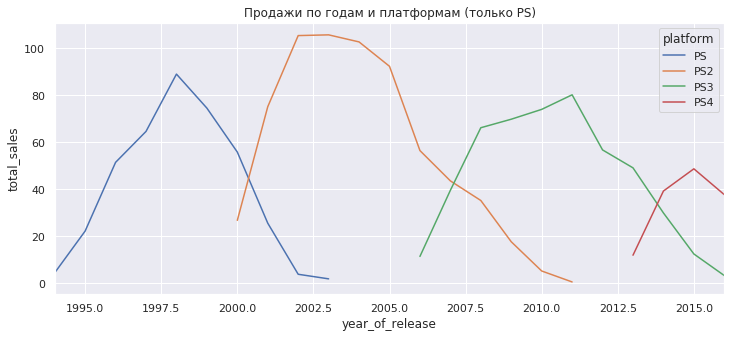

In [178]:
(data[data['platform'].isin(ps_family)]
    .pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
    .plot(figsize=(12,5), grid=True)
)
plt.ylabel('total_sales')
plt.title('Продажи по годам и платформам (только PS)')
plt.show()

**Вывод** Вот здесь смена поколений хорошо видна, можно предположить, что жизненный цикл консоли длится примерно 10 лет, но посчитаем точно, не будем мерять линейкой по экрану.

Сводная таблица со средним жизненным циклом по платформам.

In [179]:
average_platform_lifecycle = data.pivot_table(index='platform', values='year_of_release',
                                              aggfunc=lambda x: x.max()-x.min()).mean()[0]

То же самое, но только взяты лучшие по продадам платформы за всё время.

In [180]:
average_platform_lifecycle_top_10 = (data[data['platform']
                                          .isin(top10_platforms_list)]
                                          .pivot_table(index='platform', values='year_of_release',
                                                       aggfunc=lambda x: x.max()-x.min()).mean()[0]
                                    )  

Отдельно рассматриваем в том же контексте PS семейство.

In [181]:
average_platform_lifecycle_ps_family = (data[data['platform'].isin(ps_family)]
                                        .pivot_table(index='platform', values='year_of_release',
                                                     aggfunc=lambda x: x.max()-x.min()).mean()[0]
                                       )                                   

Объединяем всё в один DF.

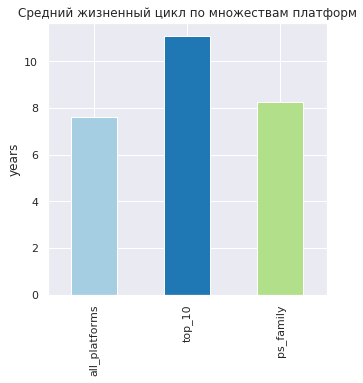

In [182]:
average_platforms_lifecycle = pd.Series(data=[average_platform_lifecycle, 
                                              average_platform_lifecycle_top_10,
                                              average_platform_lifecycle_ps_family],
                                              index=['all_platforms', 'top_10', 'ps_family']
                                       )

average_platforms_lifecycle.plot(kind='bar', color=plt.cm
                                 .Paired(np.arange(len(average_platforms_lifecycle))),
                                 figsize=(5,5), grid=True
                                )
plt.ylabel('years')
plt.title('Средний жизненный цикл по множествам платформ')
plt.show()

**Вывод** Видно, что с среднем платформы живут около 8 лет, правда в ТОП-10 это не так, за 10 лет, видимо, поправка идёт за счёт вечно живых вроде DC, что бы это не было, DreamCast, возможно.

Половина периода, после резского спада в 2012 году. Поэтому в качестве актуального периода будем рассматривать период за последние 4 года, то есть с 2013 по 2016.

## Актуальный период

In [183]:
actual_platform_data = data.pivot_table(index='platform', columns='year_of_release',
                                        values='total_sales', aggfunc='sum')

columns_left = [i for i in actual_platform_data.columns if  i > 2012 ]
actual_platform_data = actual_platform_data[columns_left].dropna()
actual_platform_data.sort_values(by=2016, ascending=False)

year_of_release,2013.0,2014.0,2015.0,2016.0
platform,,,,
PS4,11.84,39.18,48.65,37.64
XOne,11.56,28.69,31.48,18.48
3DS,19.38,14.52,14.61,5.57
PC,9.34,9.55,7.27,4.94
WiiU,14.26,11.19,9.87,4.38
PSV,8.97,9.32,5.37,3.69
PS3,49.06,29.85,12.37,3.17
X360,36.13,24.48,9.91,1.51
Wii,3.99,2.38,0.94,0.18


**Вывод** Оставляем данные по платформам только за актуальный период. Если где-то пропущены значения значит они не актуальны и мы их дропаем.

Сортируем всё по 2016 году и видим, какие платформы продаются лучше всего в 2016.

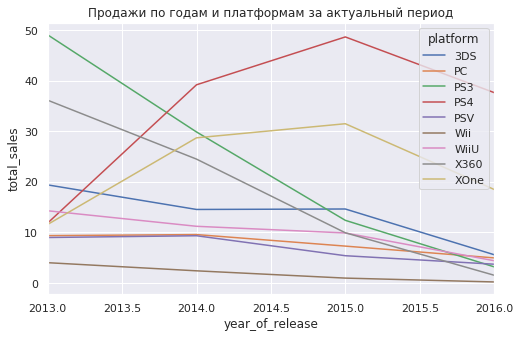

In [184]:
actual_platform_data.T.plot(figsize=(8,5), grid=True)
plt.ylabel('total_sales')
plt.title('Продажи по годам и платформам за актуальный период')
plt.show()

**Вывод** То же самое, но в виде графиков. Видим, как продажи неуклонно идут на спад по всем платформам, только у PS4 и XOne этот спад начался значительно позже, с 2015 года.

На глаз сложно понять динамику продаж по каждой платформе за актуальный период, поэтому вычислим коэффициент роста/падения год к году.

In [185]:
#Функция считает процентное изменение за каждый год,
#а потом находит среднее по полученным данным за весь период.
def growth_year_to_year(row):
    growth = []
    for i in range(len(row)-1):    
        temp = (row[2013+i+1] / row[2013+i] - 1) * 100
        growth.append(temp)
    return np.mean(growth)

In [186]:
actual_platform_data['progress'] = actual_platform_data.apply(growth_year_to_year, axis=1)

In [187]:
actual_platform_data['total_sales'] = (actual_platform_data[2013] 
                                           + actual_platform_data[2014] 
                                           + actual_platform_data[2015] 
                                           + actual_platform_data[2016]
                                          )

In [188]:
actual_platform_data.sort_values(by='progress', ascending=False)

year_of_release,2013.0,2014.0,2015.0,2016.0,progress,total_sales
platform,,,,,,
PS4,11.84,39.18,48.65,37.64,77.483873,137.31
XOne,11.56,28.69,31.48,18.48,38.870658,90.21
PC,9.34,9.55,7.27,4.94,-17.891823,31.10
PSV,8.97,9.32,5.37,3.69,-23.254998,27.35
3DS,19.38,14.52,14.61,5.57,-28.777664,54.08
WiiU,14.26,11.19,9.87,4.38,-29.649366,39.70
PS3,49.06,29.85,12.37,3.17,-57.363028,94.45
X360,36.13,24.48,9.91,1.51,-58.841837,72.03
Wii,3.99,2.38,0.94,0.18,-60.568714,7.49


**Вывод** Лучшую динамику позаказала PS4 (рост год/год 74%), несколько от неё остаёт XOne (рост год/год 45%). Все остальные платформы резко отстают, у них отрицательная данамика.

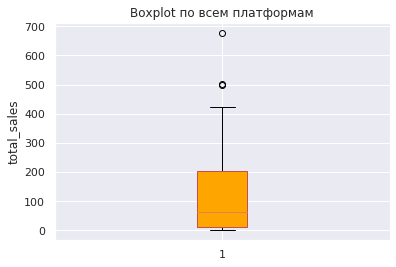

In [189]:
plt.boxplot(platform_total_sales_data, patch_artist=True, 
            boxprops=dict(facecolor='orange', color='r'))

plt.ylabel('total_sales')
plt.title('Boxplot по всем платформам')
plt.show()

In [190]:
platform_total_sales_data.sort_values(ascending=False).head()

platform
PS2     677.63
X360    501.17
PS3     498.39
DS      422.19
Wii     406.56
Name: total_sales, dtype: float64

**Вывод** Действительно, есть выдающиеся платформы по совокупным продажам. Список чемпионов выше.

Составим список платформ наиболее динамично развивающихся в атуальный период. Разместим их по возрастанию по этому критерию.

In [191]:
top_platforms_2013_2016 = (actual_platform_data
                           .sort_values(by='progress', ascending=False)
                           .index.to_list()
)

In [192]:
top_platforms_2013_2016

['PS4', 'XOne', 'PC', 'PSV', '3DS', 'WiiU', 'PS3', 'X360', 'Wii']

Возьмём данные только для этих платформ и посмотрим на общие продажи по этим платформам.

In [193]:
data_top_platforms = data.query('platform in @top_platforms_2013_2016')

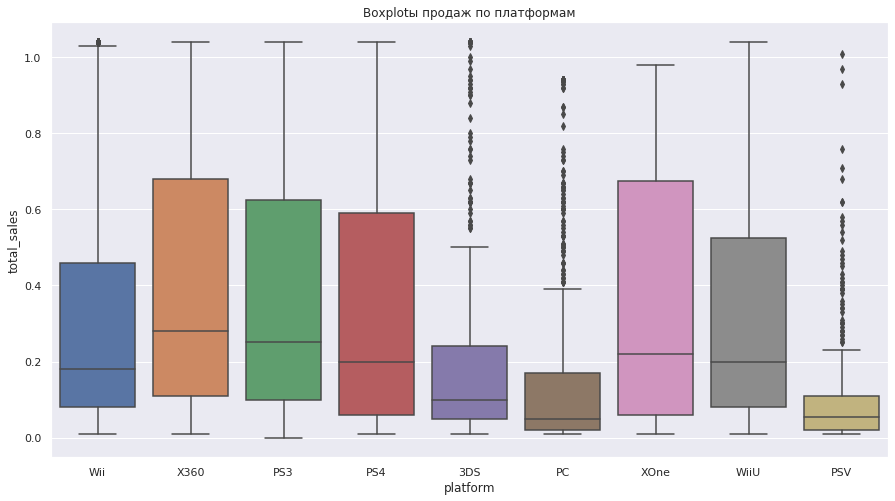

In [194]:
plt.figure(figsize=(15,8))
sns.boxplot(x='platform', y='total_sales', data=data_top_platforms)
plt.title('Boxplotы продаж по платформам')
plt.show()

**Вывод** Большое количество выбросов может говорить о том, что действительно больших успехов по продажам добиваются единичные игры.

Рассмотрим данные подальше от выбросов.

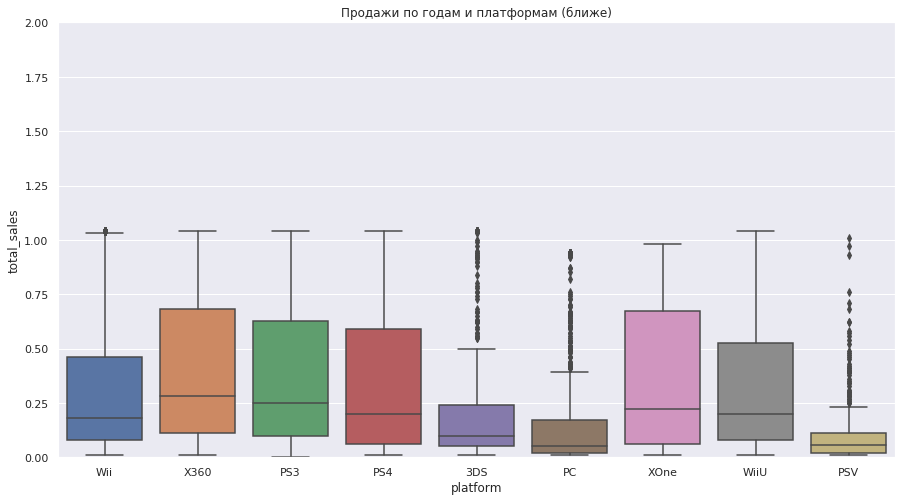

In [195]:
plt.figure(figsize=(15,8))
plt.ylim(0, 2)
sns.boxplot(x='platform', y='total_sales', data=data_top_platforms)
plt.ylabel('total_sales')
plt.title('Продажи по годам и платформам (ближе)')
plt.show()

**Вывод** Медианные значения говорят о том, что типичная игра добивается примерно одинакового успеха по продажам, хотя здесь выделяются популярные семейства PS и Х. Но кассу для каждой из платформ делают чемпионы, чьи продажи значительно выше продаж типичной игры для платформы.

## PS4 против всех

In [196]:
PS4_data = data[data['platform']=='PS4']
not_PS4_data = data[data['platform'] !='PS4']

Как оценки пользователей и критиков влияют на продажи игр PS4?

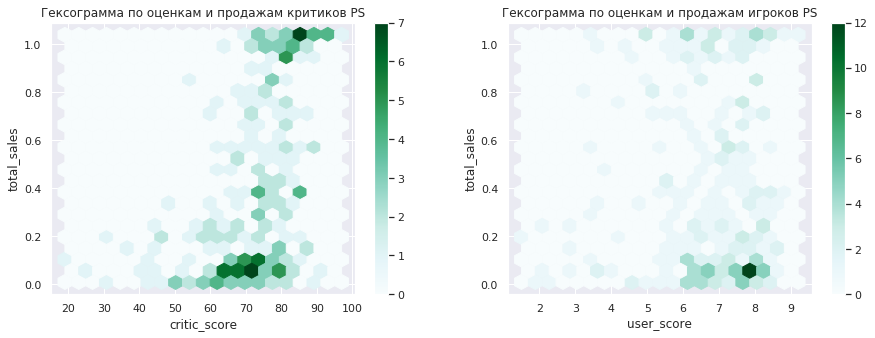

In [197]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 5))
PS4_data.plot(x='critic_score', y='total_sales', kind='hexbin', gridsize=20, sharex=False,
              figsize=(15,5), ax=axs[0], title='Гексограмма по оценкам и продажам критиков PS')
plt.title('Гексограмма по оценкам и продажам')
PS4_data.plot(x='user_score', y='total_sales', kind='hexbin', gridsize=20, sharex=False,
              figsize=(15,5), ax=axs[1], title='Гексограмма по оценкам и продажам игроков PS')
plt.show()

**Вывод** Видно, что основной массив игр сосредоточен возле 0-х продаж в диапазоне оценок 6-9. При этом Пользователи предпочитают оценки ставить играм чуть выше чем Критики, да и вариативность оценок у Пользователей ниже.

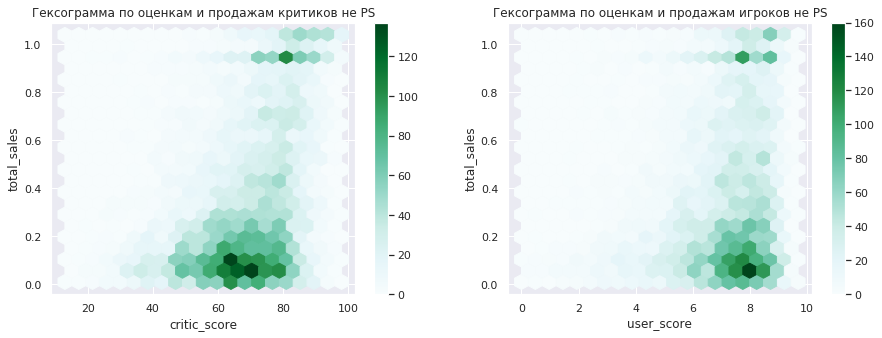

In [198]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 5))
not_PS4_data.plot(x='critic_score', y='total_sales', kind='hexbin', gridsize=20, sharex=False,
              figsize=(15,5), ax=axs[0], title='Гексограмма по оценкам и продажам критиков не PS')
not_PS4_data.plot(x='user_score', y='total_sales', kind='hexbin', gridsize=20, sharex=False,
              figsize=(15,5), ax=axs[1], title='Гексограмма по оценкам и продажам игроков не PS')
plt.show()

**Вывод** Критики и Пользователи чуть больше любят игры на PS4, при этом разброс оценок игры не на PS4 заметно выше.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


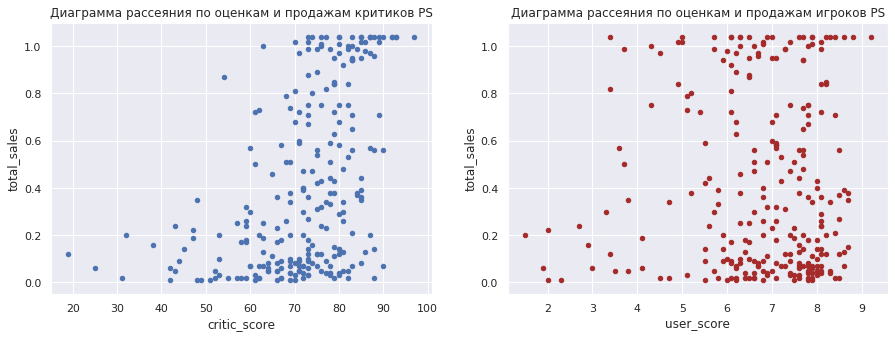

In [199]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 5))
PS4_data.plot(x='critic_score', y='total_sales', kind='scatter',
              figsize=(15,5), ax=axs[0],
              title='Диаграмма рассеяния по оценкам и продажам критиков PS')
PS4_data.plot(x='user_score', y='total_sales', kind='scatter', color='brown',
              figsize=(15,5), ax=axs[1],
             title='Диаграмма рассеяния по оценкам и продажам игроков PS')
plt.show()

**Вывод** Видна корреляция между оценкой критиков и уровнем продаж (чем больше оценка - тем выше продажа, чего не скажешь об оценках пользователей. Там всё более хаотично, сложно вычленить тенденцию.

Но в обоих случаях, всё-таки, более успешные продажи сосредоточены в области, где оценки превышают 6 (60%).

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


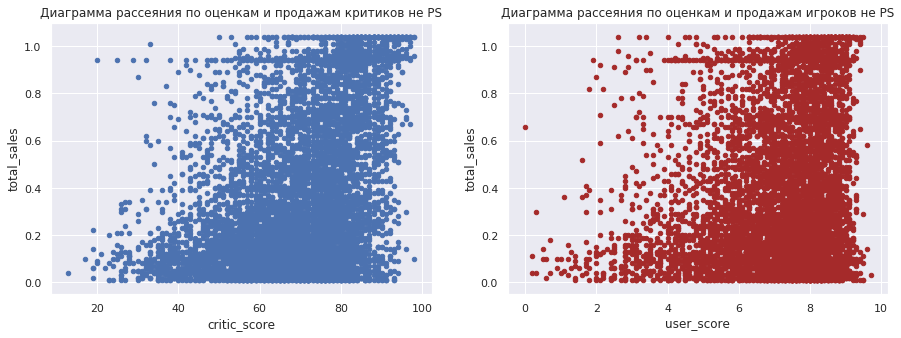

In [200]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 5))
not_PS4_data.plot(x='critic_score', y='total_sales', kind='scatter',
              figsize=(15,5), ax=axs[0],
              title='Диаграмма рассеяния по оценкам и продажам критиков не PS')
not_PS4_data.plot(x='user_score', y='total_sales', kind='scatter', color='brown',
              figsize=(15,5), ax=axs[1],
              title='Диаграмма рассеяния по оценкам и продажам игроков не PS')
plt.show()

В этом хаосе сложно сделать какие-либо выводы, поэтому и была выше применена диаграмма типа `hexbin`.

Установим эту корреляцию численно.

In [201]:
pirson_print(PS4_data, 'critic_score', 'total_sales')
pirson_print(PS4_data, 'user_score', 'total_sales')

Коэффициент корреляции между critic_score и total_sales: 0.48
Коэффициент корреляции между user_score и total_sales: -0.00


**Вывод** Численные значения лишь подтверждают выводы, сделанные на основе диаграмм: 0.43 - корреляция между продажами и оценками критиков есть, но она средняя. А вот оценки пользователей никак не влияют на продажи.

In [202]:
pirson_print(not_PS4_data, 'critic_score', 'total_sales')
pirson_print(not_PS4_data, 'user_score', 'total_sales')

Коэффициент корреляции между critic_score и total_sales: 0.39
Коэффициент корреляции между user_score и total_sales: 0.16


**Вывод** А вот не на PS4 влияние критиков снижается, а пользователей растёт, при этом всё равно такую корреляцию нужно назвать слабой.

## Битва жанров

In [203]:
genre_total_sales_data = data.groupby('genre')['total_sales'].sum()

Группируем по жанрам, нас по-прежнему интересует уровень продаж.

In [204]:
genre_total_sales_data.sort_values(ascending=False)

genre
Action          1012.76
Sports           715.46
Shooter          485.36
Misc             428.44
Racing           384.10
Role-Playing     376.42
Platform         336.79
Fighting         260.03
Simulation       220.71
Adventure        167.49
Puzzle           117.34
Strategy         106.53
Name: total_sales, dtype: float64

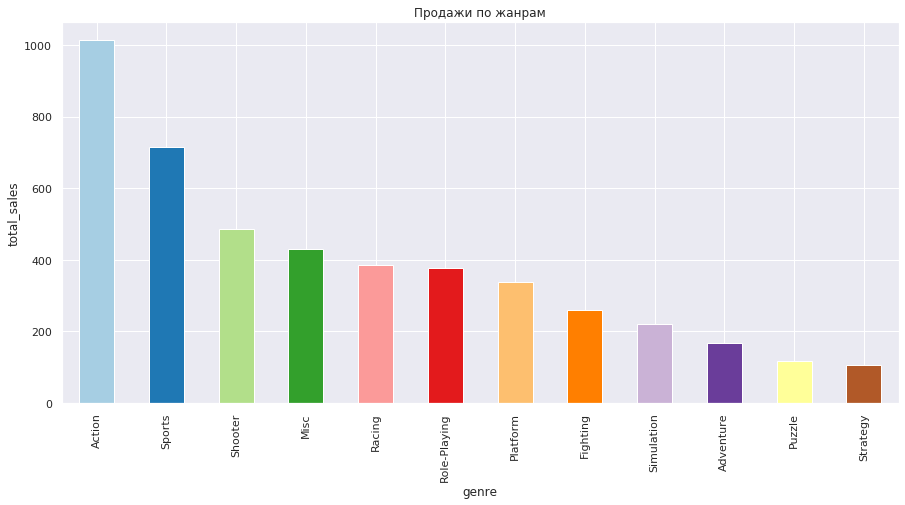

In [205]:
genre_total_sales_data.sort_values(ascending=False).plot(kind='bar', color=plt.cm.Paired(
    np.arange(len(genre_total_sales_data))), figsize=(15,7), grid=True)
plt.ylabel('total_sales')
plt.title('Продажи по жанрам')
plt.show()

**Вывод** Уверенно лидирует жанр Action, на втором месте неожиданно Sport, на 3-м Shooter. Strategy, к сожалению, на последнем. Воистину, пользователь стремится к более казуальным жанрам, когда не надо напрягаться и трайхардить.

In [206]:
genre_critic_score_data = data.groupby('genre')['critic_score'].mean()

А какие жанры любят больше всего критики?

In [207]:
genre_critic_score_data.sort_values(ascending=False)

genre
Role-Playing    72.652646
Strategy        72.086093
Sports          71.968174
Shooter         70.181144
Fighting        69.217604
Simulation      68.619318
Platform        68.058350
Racing          67.963612
Puzzle          67.424107
Action          66.629101
Misc            66.619503
Adventure       65.331269
Name: critic_score, dtype: float64

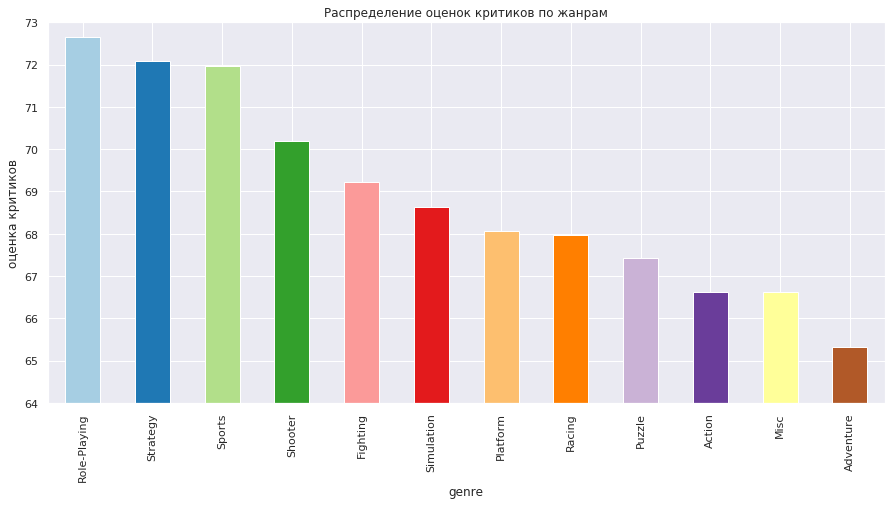

In [208]:
genre_critic_score_data.sort_values(ascending=False).plot(kind='bar', color=plt.cm.Paired(
    np.arange(len(genre_total_sales_data))), figsize=(15,7), ylim=(64, 73), grid=True)
plt.ylabel('оценка критиков')
plt.title('Распределение оценок критиков по жанрам')
plt.show()

**Вывод** Удивительно, но картина чуть ли не противоположная: Stategy, RPG наверху, правда и Sport там, а вот Action, Adventure внизу.

Что же, высокая оценка критиков за спорт действительно совпадает с высокими продажами.

In [209]:
join_critic_sales = genre_total_sales_data.to_frame()
join_critic_sales = join_critic_sales.merge(genre_critic_score_data.to_frame(), on='genre')

Создаём DF по жанрам, где будут и оценки критиков и уровни продаж.

In [210]:
pirson_print(join_critic_sales, 'total_sales', 'critic_score')

Коэффициент корреляции между total_sales и critic_score: -0.01


**Вывод** Но сказать, что критики определяют, какой жанр будет продаваться лучше всего никак нельзя!

# 3. Сравниваем

Соберём данные по разным регионам в DF `combine_regions`. Объединим информацию по платформам, продажам, а также долю, которую занимает та или иная платформа в регионе.

In [211]:
na_favorite_platform = data.groupby('platform')['na_sales'].sum()

In [212]:
na_favorite_platform.sort_values(ascending=False).head(10)

platform
PS2     372.63
X360    319.06
DS      272.58
Wii     268.33
PS3     260.80
PS      212.94
XB      150.32
GBA     139.10
GC      102.50
PSP      96.00
Name: na_sales, dtype: float64

В Северной Америке.

In [213]:
eu_favorite_platform = data.groupby('platform')['eu_sales'].sum()

In [214]:
eu_favorite_platform.sort_values(ascending=False).head(10)

platform
PS2     186.82
PS3     147.15
X360    129.79
PS      116.77
Wii      89.87
PC       73.01
DS       71.56
GBA      53.57
XB       49.26
PS4      46.16
Name: eu_sales, dtype: float64

Европе.

In [215]:
jp_favorite_platform = data.groupby('platform')['jp_sales'].sum()

In [216]:
jp_favorite_platform.sort_values(ascending=False).head(10)

platform
PS2     49.67
DS      48.36
PS3     41.74
PSP     40.43
PS      35.20
3DS     25.58
SNES    21.20
PSV     16.87
Wii     16.59
SAT     14.62
Name: jp_sales, dtype: float64

Японии.

In [217]:
combine_regions = na_favorite_platform.to_frame().merge(eu_favorite_platform, on='platform')
combine_regions = combine_regions.merge(jp_favorite_platform, on='platform')
combine_regions['total_sales'] = (combine_regions['na_sales'] + combine_regions['eu_sales'] 
                                + combine_regions['jp_sales']
)
combine_regions = combine_regions.sort_values('total_sales', ascending=False)

Собираем информацию по регионам в одном месте.

И считаем, какую долю занимает та или иная платформа по продажам в регионе.

In [218]:
na_sum = data['na_sales'].sum()
eu_sum = data['eu_sales'].sum()
jp_sum = data['jp_sales'].sum()
combine_regions['na_ratio'] = combine_regions['na_sales'] / na_sum
combine_regions['eu_ratio'] = combine_regions['eu_sales'] / eu_sum
combine_regions['jp_ratio'] = combine_regions['jp_sales'] / jp_sum

Отобразим продажи по платформам в разрезе регионов.

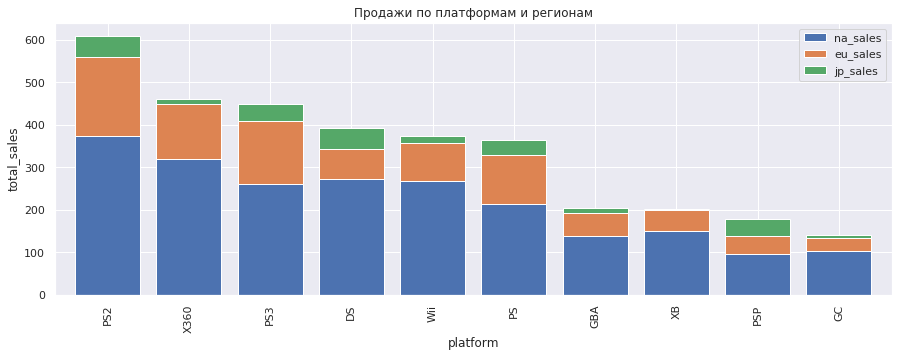

In [219]:
(combine_regions[['na_sales', 'eu_sales', 'jp_sales']]
    .head(10)
    .plot(kind='bar', width=0.8, stacked=True, grid=True, figsize=(15, 5))
)
plt.ylabel('total_sales')
plt.title('Продажи по платформам и регионам')
plt.show()

А также доли, которые занимают платформы в каждом из регионов.

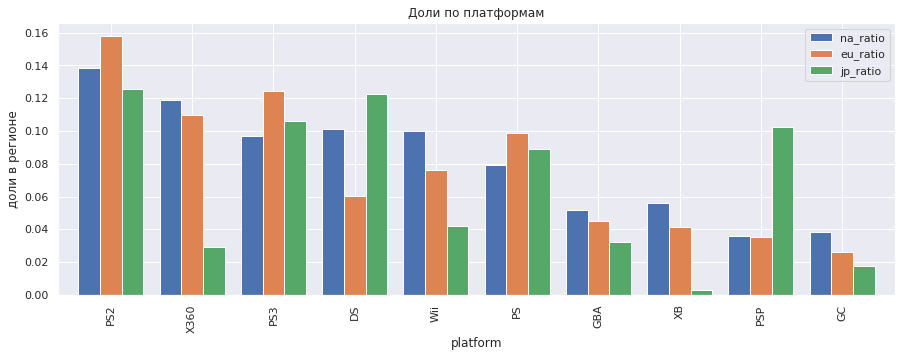

In [220]:
(combine_regions[['na_ratio', 'eu_ratio', 'jp_ratio']]
    .head(10)
    .plot(kind='bar', width=0.8, grid=True, figsize=(15, 5))
)
plt.ylabel('доли в регионе')
plt.title('Доли по платформам')
plt.show()

**Вывод** 

Топ-3 Северной Америки:
1. PS2
2. X360
3. Wii

Топ-3 Европы:
1. PS2
2. PS3
3. X360

Топ-3 Японии:
1. PS2
2. DS
3. PS

Общие выводы: Северная Америка значительно лидирует по доле продаж, Япония - в остающих. Абслоютный лидер среди платформ PS2 - 1-ое место в кажом из регионов, Американцы патриотично отдают предпочтение также X360, в вот японцы играю только в своих платформах, доля X360 крайне низка. Европейцы предпочитаю играть в PS, но не забывают и о X360, при этом доля PS3 заметно выше.

# 4.Портрет пользователя

Ещё раз ТОП-5 по доли по регионам, но теперь в виде списков.

### По платформам

In [221]:
combine_regions.sort_values('na_ratio', ascending=False).head()

,na_sales,eu_sales,jp_sales,total_sales,na_ratio,eu_ratio,jp_ratio
platform,,,,,,,
PS2,372.63,186.82,49.67,609.12,0.138710,0.158001,0.125906
X360,319.06,129.79,11.42,460.27,0.118769,0.109768,0.028948
DS,272.58,71.56,48.36,392.50,0.101467,0.060521,0.122586
Wii,268.33,89.87,16.59,374.79,0.099885,0.076006,0.042053
PS3,260.80,147.15,41.74,449.69,0.097082,0.124450,0.105805


In [222]:
combine_regions.sort_values('eu_ratio', ascending=False).head()

,na_sales,eu_sales,jp_sales,total_sales,na_ratio,eu_ratio,jp_ratio
platform,,,,,,,
PS2,372.63,186.82,49.67,609.12,0.138710,0.158001,0.125906
PS3,260.80,147.15,41.74,449.69,0.097082,0.124450,0.105805
X360,319.06,129.79,11.42,460.27,0.118769,0.109768,0.028948
PS,212.94,116.77,35.20,364.91,0.079266,0.098757,0.089227
Wii,268.33,89.87,16.59,374.79,0.099885,0.076006,0.042053


In [223]:
combine_regions.sort_values('jp_ratio', ascending=False).head()

,na_sales,eu_sales,jp_sales,total_sales,na_ratio,eu_ratio,jp_ratio
platform,,,,,,,
PS2,372.63,186.82,49.67,609.12,0.138710,0.158001,0.125906
DS,272.58,71.56,48.36,392.50,0.101467,0.060521,0.122586
PS3,260.80,147.15,41.74,449.69,0.097082,0.124450,0.105805
PSP,96.00,41.82,40.43,178.25,0.035736,0.035369,0.102484
PS,212.94,116.77,35.20,364.91,0.079266,0.098757,0.089227


Объединим доли ТОП-5 по регионам в один DF.

In [224]:
us_ratio_sales = (combine_regions
                          .sort_values(by='na_sales', ascending=False)
                          .head()['na_ratio']
                          .reset_index(drop=True)
                          .to_frame()
                 )
                

eu_ratio_sales = (combine_regions
                          .sort_values(by='eu_sales', ascending=False)
                          .head()['eu_ratio']
                          .reset_index(drop=True)
                          .to_frame()
                 )
                  

jp_ratio_sales = (combine_regions
                          .sort_values(by='jp_sales', ascending=False)
                          .head()['jp_ratio']
                          .reset_index(drop=True)
                          .to_frame()
                 )

In [225]:
region_ratio_sales = us_ratio_sales.merge(eu_ratio_sales, left_index=True, right_index=True)
region_ratio_sales = region_ratio_sales.merge(jp_ratio_sales, left_index=True, right_index=True)

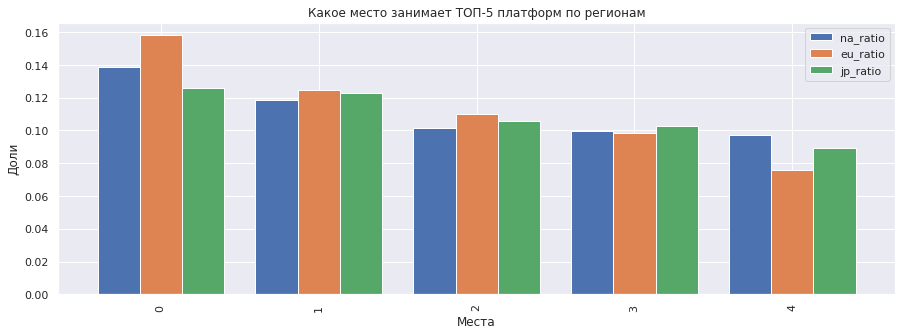

In [226]:
region_ratio_sales.plot(kind='bar', width=0.8, grid=True, figsize=(15, 5))
plt.xlabel('Места')
plt.ylabel('Доли')
plt.title('Какое место занимает ТОП-5 платформ по регионам')
plt.show()

**Вывод** Распределение долей по платформам в Японии более однородное, хотя разницу существенной не назовёшь. В Европе наоборот первые две позиции занимают чуть более доминирующее положение.

### По жанрам

Проделываем с жанрами всё то же самое, что и с платформами.

In [227]:
na_favorite_genre = data.groupby('genre')['na_sales'].sum()
na_favorite_genre.sort_values(ascending=False).head()

genre
Action     590.30
Sports     444.77
Shooter    289.28
Misc       257.32
Racing     227.00
Name: na_sales, dtype: float64

In [228]:
eu_favorite_genre = data.groupby('genre')['eu_sales'].sum()
eu_favorite_genre.sort_values(ascending=False).head()

genre
Action     273.58
Sports     170.91
Shooter    138.33
Racing     113.70
Misc       104.42
Name: eu_sales, dtype: float64

In [229]:
jp_favorite_genre = data.groupby('genre')['jp_sales'].sum()
jp_favorite_genre.sort_values(ascending=False).head()

genre
Role-Playing    79.37
Action          69.79
Sports          43.47
Misc            33.67
Adventure       32.29
Name: jp_sales, dtype: float64

In [230]:
combine_regions_genre = na_favorite_genre.to_frame().merge(eu_favorite_genre, on='genre')
combine_regions_genre = combine_regions_genre.merge(jp_favorite_genre, on='genre')
combine_regions_genre['total_sales'] = (combine_regions_genre['na_sales'] 
                    + combine_regions_genre['eu_sales'] + combine_regions_genre['jp_sales']
)
combine_regions_genre = combine_regions_genre.sort_values('total_sales', ascending=False)

In [231]:
combine_regions_genre['na_ratio'] = combine_regions_genre['na_sales'] / na_sum
combine_regions_genre['eu_ratio'] = combine_regions_genre['eu_sales'] / eu_sum
combine_regions_genre['jp_ratio'] = combine_regions_genre['jp_sales'] / jp_sum
combine_regions_genre.head()

,na_sales,eu_sales,jp_sales,total_sales,na_ratio,eu_ratio,jp_ratio
genre,,,,,,,
Action,590.30,273.58,69.79,933.67,0.219737,0.231377,0.176907
Sports,444.77,170.91,43.47,659.15,0.165564,0.144545,0.110190
Shooter,289.28,138.33,20.26,447.87,0.107684,0.116991,0.051356
Misc,257.32,104.42,33.67,395.41,0.095787,0.088312,0.085349
Racing,227.00,113.70,12.87,353.57,0.084500,0.096160,0.032624


По-прежнему, самые популярные жанры:

1. Action
2. Sports
3. Shooter

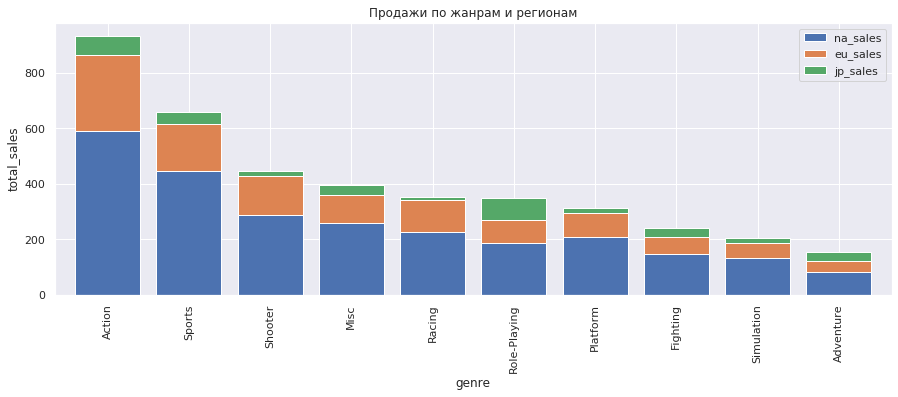

In [232]:
(combine_regions_genre[['na_sales', 'eu_sales', 'jp_sales']]
    .head(10)
    .plot(kind='bar', width=0.8, stacked=True, grid=True, figsize=(15, 5))
)
plt.ylabel('total_sales')
plt.title('Продажи по жанрам и регионам')
plt.show()

**Вывод** По объёмам продаж главный рынок сбыта - Северная Америка. Японцы в отстающих, но РПГ лучше продавать в Японии.

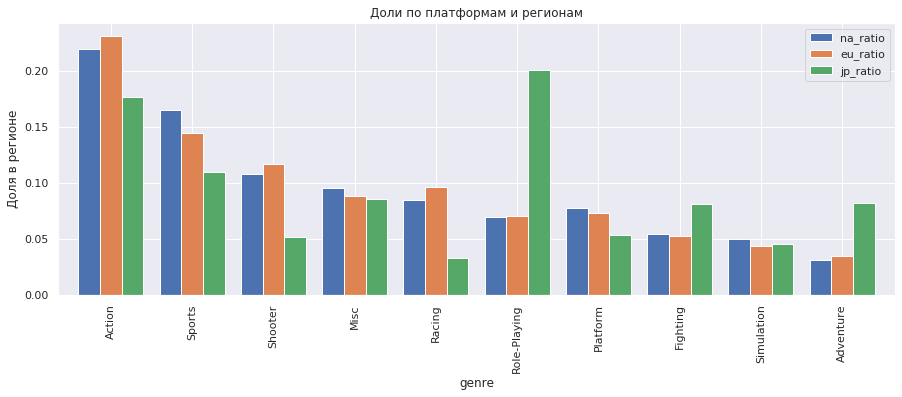

In [233]:
(combine_regions_genre[['na_ratio', 'eu_ratio', 'jp_ratio']]
    .head(10)
    .plot(kind='bar', width=0.8, grid=True, figsize=(15, 5))
)
plt.ylabel('Доля в регионе')
plt.title('Доли по платформам и регионам')
plt.show()

**Вывод** 

Американцы и Европейцы в выборе жанра единодушны:

1. Action
2. Sports
3. Shooter

А вот японцы, как всегда, оригинальны: Не любят жанр Shooter, но Role-Playing почти четверть японского рынка.

In [234]:
us_ratio_sales_genre = (combine_regions_genre
                          .sort_values(by='na_sales', ascending=False)
                          .head()['na_ratio']
                          .reset_index(drop=True)
                          .to_frame()
                       )
                

eu_ratio_sales_genre = (combine_regions_genre
                          .sort_values(by='eu_sales', ascending=False)
                          .head()['eu_ratio']
                          .reset_index(drop=True)
                          .to_frame()
                       )
                  

jp_ratio_sales_genre = (combine_regions_genre
                          .sort_values(by='jp_sales', ascending=False)
                          .head()['jp_ratio']
                          .reset_index(drop=True)
                          .to_frame()
                       )

Запаковываем информацию о ТОП-5 жанрах по регионам в один DF.

In [235]:
region_ratio_sales_genre = (us_ratio_sales_genre
                            .merge(eu_ratio_sales_genre, left_index=True, right_index=True)
                           )
region_ratio_sales_genre = (region_ratio_sales_genre
                            .merge(jp_ratio_sales_genre, left_index=True, right_index=True)
                           )

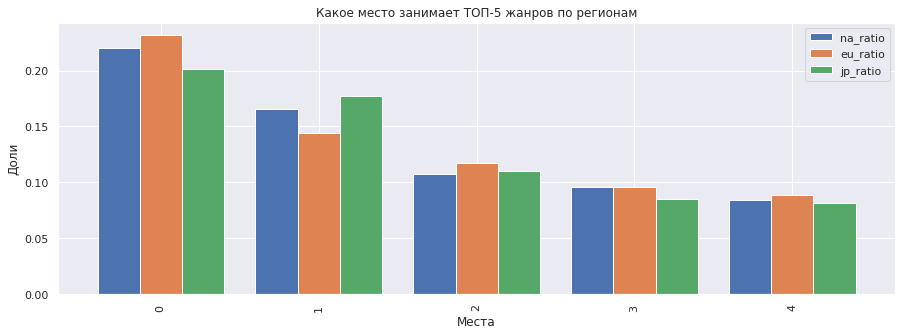

In [236]:
region_ratio_sales_genre.plot(kind='bar', width=0.8, grid=True, figsize=(15, 5))
plt.xlabel('Места')
plt.ylabel('Доли')
plt.title('Какое место занимает ТОП-5 жанров по регионам')
plt.show()

**Вывод** Существенных кренов по позициям в ТОП-5 не обнаружено. Т.е. в разных регионах 1-е, 2-е место занимают примерно оданковую долю рынка, разница в несколько процентов. Предположу, что это универсальный закон, и регион тут не при чём.

Если сравивать с платформами, то вкусовые предпочтения по платформам распределены более равномерно, там 1-е место не превоходит 15%.

Усрешность продаж определяет в большей степени жанр нежели платформа.

### Влияет ли рейтнг на продажи?

In [237]:
column_info(data, 'rating')


*** Информация по столбцу rating ***

Тип данных столбца rating: object:
В столбце rating пропущено 0 из 16715 строк, что составляет 0.00%

Количество значений в каждой из категорий:
no_rating    6766
E            3990
T            2961
M            1563
E10+         1420
EC              8
RP              3
K-A             3
AO              1
Name: rating, dtype: int64



Первые 4 важны, остальных слишком мало, чтобы рассматривать. Adults Only только 1 игрушка. Интересно, что там?

In [238]:
rating_list = ['E', 'T', 'M', 'E10+', 'no_rating']

In [239]:
rating_data = data.query('rating in @rating_list')

Ограничили данные только этими 4 рейтингами.

Определим как в среднем продаётся игра в зависимости от рейтинга в каждом из регионов.

In [240]:
total_rating_sales = rating_data.groupby('rating')['total_sales'].mean()
na_rating_sales = rating_data.groupby('rating')['na_sales'].mean()
eu_rating_sales = rating_data.groupby('rating')['eu_sales'].mean()
jp_rating_sales = rating_data.groupby('rating')['jp_sales'].mean()
total_rating_sales = total_rating_sales.to_frame()                         
total_rating_sales = total_rating_sales.merge(na_rating_sales, left_index=True, right_index=True)
total_rating_sales = total_rating_sales.merge(eu_rating_sales, left_index=True, right_index=True)
total_rating_sales = total_rating_sales.merge(jp_rating_sales, left_index=True, right_index=True)
                     
total_rating_sales

,total_sales,na_sales,eu_sales,jp_sales
rating,,,,
E,0.313150,0.203025,0.076203,0.009622
E10+,0.307599,0.189120,0.081479,0.009204
M,0.418215,0.237236,0.126097,0.019546
T,0.311888,0.183634,0.084124,0.017943
no_rating,0.198778,0.102016,0.046666,0.038318


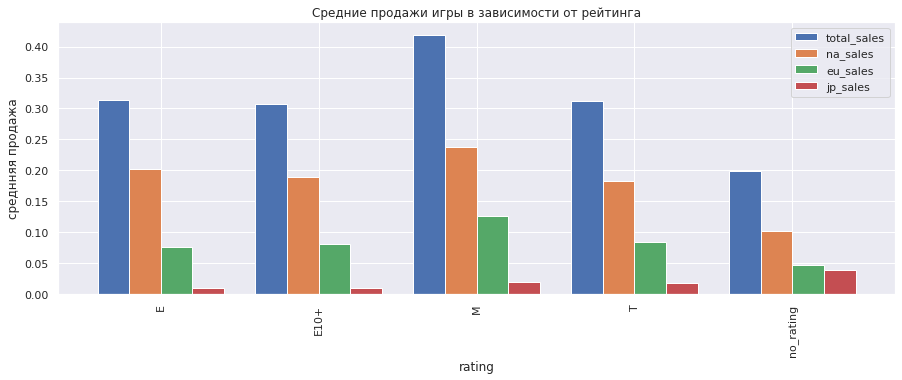

In [241]:
total_rating_sales.plot(kind='bar', width=0.8, grid=True, figsize=(15, 5))
plt.ylabel('среднняя продажа')
plt.title('Средние продажи игры в зависимости от рейтинга')
plt.show()

**Вывод** Игры с рейтингом M (Mature) продаются лучше всего в каждом из регионов, настоящего геймера насильем и матом не остановить.

In [242]:
total_rating_sales['na_sales'].sort_values(ascending=False)

rating
M            0.237236
E            0.203025
E10+         0.189120
T            0.183634
no_rating    0.102016
Name: na_sales, dtype: float64

In [243]:
total_rating_sales['eu_sales'].sort_values(ascending=False)

rating
M            0.126097
T            0.084124
E10+         0.081479
E            0.076203
no_rating    0.046666
Name: eu_sales, dtype: float64

In [244]:
total_rating_sales['jp_sales'].sort_values(ascending=False)

rating
no_rating    0.038318
M            0.019546
T            0.017943
E            0.009622
E10+         0.009204
Name: jp_sales, dtype: float64

**Вывод** Японцы опять отличились: рейтинг в их случае не отказывает такого же влияния на продажи как к Америке или Европе.

В Америке и Европе предпочитают игры с рейтингом M, а вот остальные рейтинги там продаются примерно одинаково.

# 5. Гипотезы

In [245]:
column_info(data, 'platform')


*** Информация по столбцу platform ***

Тип данных столбца platform: object:
В столбце platform пропущено 0 из 16715 строк, что составляет 0.00%

Количество значений в каждой из категорий:
PS2     2161
DS      2151
PS3     1331
Wii     1320
X360    1262
PSP     1209
PS      1197
PC       974
XB       824
GBA      822
GC       556
3DS      520
PSV      430
PS4      392
N64      319
XOne     247
SNES     239
SAT      173
WiiU     147
2600     133
GB        98
NES       98
DC        52
GEN       29
NG        12
SCD        6
WS         6
3DO        3
TG16       2
GG         1
PCFX       1
Name: platform, dtype: int64



Постараемся ответить на вопрос: Сильно ли отличаются дивергенции двух выборок. Для этого найдём максамальный размах обеих выборок и на него поделим разность двух дивергенций. Будем считать отличие небольшим (для применения `equal_var = True`), если полученное значение меньше 10%.

In [246]:
range1 = data.loc[data['platform']=='XOne', 'user_score'].max() - data.loc[data['platform']=='XOne',
                                                                  'user_score'].min()
var1 = np.var(data.loc[data['platform']=='XOne', 'user_score'])
range2 = data.loc[data['platform']=='PC', 'user_score'].max() - data.loc[data['platform']=='PC',
                                                                  'user_score'].min()
var2 = np.var(data.loc[data['platform']=='PC', 'user_score'])

`range 1, rangr2` - размах, а `var1, var2` - дивергенции соотвествующих выборок.

Соответвующие выборки - это оценки пользователей по платформам XOne и PC.

In [247]:
'{:.2%}'.format(abs(var1 - var2) / max(range1, range2))

'5.59%'

Будем считать дисперсию выборок "примерно" одинаковыми:


*** Информация по столбцу user_score ***

Тип данных столбца user_score: float64:
В столбце user_score пропущено 65 из 247 строк, что составляет 26.32%
Минимальное значение: 1.60
Максимальное значение: 9.20
Среднее значение: 6.52
Медианное значение: 6.80


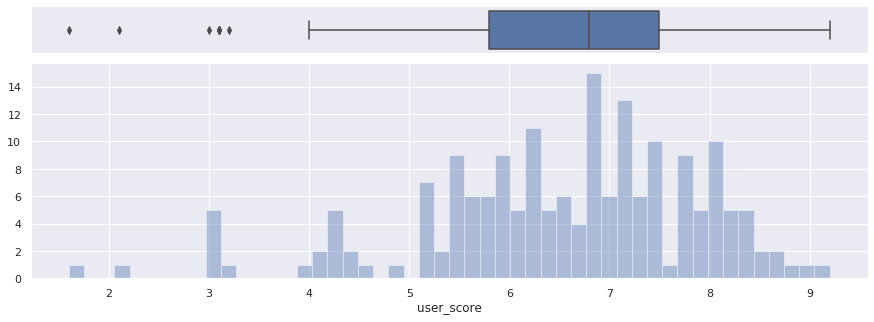

In [248]:
column_info(data[data['platform']=='XOne'], 'user_score', quantitative=True)


*** Информация по столбцу user_score ***

Тип данных столбца user_score: float64:
В столбце user_score пропущено 204 из 974 строк, что составляет 20.94%
Минимальное значение: 1.40
Максимальное значение: 9.30
Среднее значение: 7.06
Медианное значение: 7.50


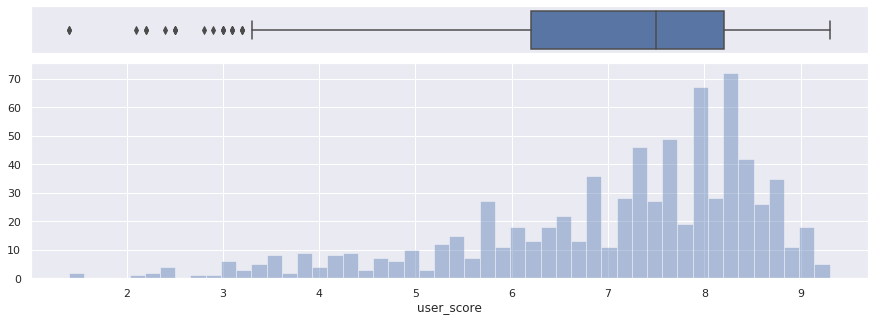

In [249]:
column_info(data[data['platform']=='PC'], 'user_score', quantitative=True)

**Вывод** По обеим платформам распределение напоминает нормальное со смещением влево. Пользователи действительно не любят ставить низкие оценки.

Н0 нулевая гипотеза: Средняя оценка пользователей по платформам XOne и PC равны.
H1 альтернативная гипотеза: Принимая во внимание среднее и медианное значения, предполагаем, что средняя оценка по платформе PC выше.

Пропущенные значения безжалостно выкидываем, так как они не несут никакой статистической информации, да и функция с `NaN` не работает. Выше мы проверили, что значений без `NaN` остаётся достаточно для полноценной выборки.

In [250]:
results = st.ttest_ind(data.loc[data['platform']=='XOne', 'user_score'].dropna(),
                       data.loc[data['platform']=='PC', 'user_score'].dropna(), equal_var = True)
print('p-значение: ', results.pvalue)

p-значение:  1.3896435533548819e-05


**Вывод** alpha тут можно взять 0.0001, даже в этот случае отвергаем H0 и, основываясь на средних и медианных значениях, заключаем, что пользователи больше любят игры на PC. (Пекабояре победили)

In [251]:
column_info(data, 'genre')


*** Информация по столбцу genre ***

Тип данных столбца genre: object:
В столбце genre пропущено 2 из 16715 строк, что составляет 0.01%

Количество значений в каждой из категорий:
Action          3369
Sports          2348
Misc            1750
Role-Playing    1498
Shooter         1323
Adventure       1303
Racing          1249
Platform         888
Simulation       873
Fighting         849
Strategy         683
Puzzle           580
Name: genre, dtype: int64



Здесь подход аналогичный с тем, что мы использовали для платформ.

In [252]:
range1 = data.loc[data['genre']=='Action', 'user_score'].max() - data.loc[data['genre']=='Action',
                                                                  'user_score'].min()
var1 = np.var(data.loc[data['genre']=='Action', 'user_score'])
range2 = data.loc[data['genre']=='Sports', 'user_score'].max() - data.loc[data['genre']=='Sports',
                                                                  'user_score'].min()
var2 = np.var(data.loc[data['genre']=='Sports', 'user_score'])

In [253]:
'{:.2%}'.format(abs(var1 - var2) / max(range1, range2))

'6.06%'

Будем брать `equal_var = True`.


*** Информация по столбцу user_score ***

Тип данных столбца user_score: float64:
В столбце user_score пропущено 1539 из 3369 строк, что составляет 45.68%
Минимальное значение: 0.30
Максимальное значение: 9.50
Среднее значение: 7.05
Медианное значение: 7.40


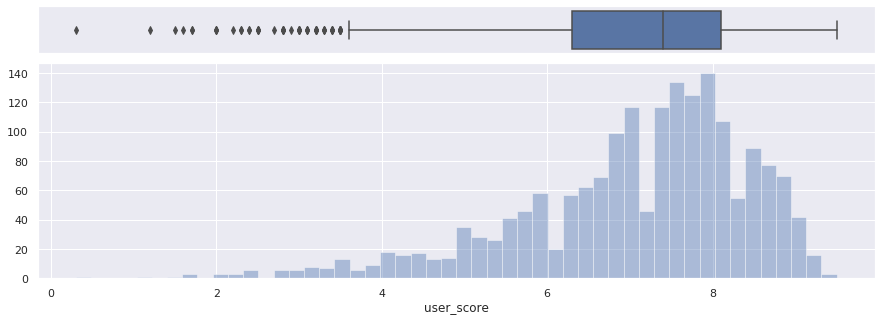

In [254]:
column_info(data[data['genre']=='Action'], 'user_score', quantitative=True)


*** Информация по столбцу user_score ***

Тип данных столбца user_score: float64:
В столбце user_score пропущено 1245 из 2348 строк, что составляет 53.02%
Минимальное значение: 0.20
Максимальное значение: 9.50
Среднее значение: 6.96
Медианное значение: 7.40


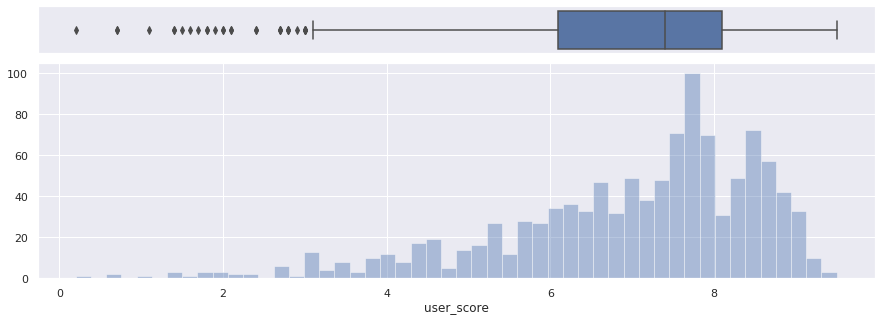

In [255]:
column_info(data[data['genre']=='Sports'], 'user_score', quantitative=True)

**Вывод** По обеим платформам распределение напоминает нормальное со смещением влево. Пользователи действительно не любят ставить низкие оценки.

Н0 нулевая гипотеза: Средняя оценка пользователей по жанрам Action и Sports равны.
H1 альтернативная гипотеза: Принимая во внимание среднее и медианное значения, предполагаем, что средняя оценка по жанру Sports выше.

Пропущенные значения безжалостно выкидываем, так как они не несут никакой статистической информации, да и функция с `NaN` не работает. Выше мы проверили, что значений без `NaN` остаётся достаточно для полноценной выборки.

In [256]:
results = st.ttest_ind(data.loc[data['genre']=='Action', 'user_score'].dropna(),
                       data.loc[data['genre']=='Sports', 'user_score'].dropna(), equal_var = True)
print('p-значение: ', results.pvalue)

p-значение:  0.10406951359049141


**Вывод** 10% - много для alpha, поэтому принимаем H0. Т.е. пользователи ставят "примерно" одинаковые оценки жанрам Action и Sports.
Средние и медианные значения действительно сильно похожи.

# 6. Общий вывод

Можно выделить эпохи развития гемдева по количеству выпускаемых игр: До 1993 года выпускали мало игр, до 2009 наблюдается бурный рост, а затем спад вплоть до 2016.

Какие планы на 2k17?

Эра доминирования PS4 объявляется открытой. Делаем акцент на этой платформе, но не забываем и про семейство XBox на американском континенте. 

В Японию с этим даже не лезем. В Японию везём РПГшки, пойдут местные платформы от Sony и Nindendo.

Ориентрируемся на оценки критиков, но без фанатизма. На оценки пользователей можно не обращать внимание.

В последние годы геймеры предпочитают жанры Action, Sports и Shooter. На них и делаем акцент.

В Японию можно везти игры с любым рейтнгом, либо им всё равно, либо у них свой блэкджек. А вот для максимизации продаж в Америке и Европе предпочтение лучше отдавать рейтингу M (Mature).

Ну и точечные исследования показывают, что пользователи статистически одинаково любят жанты Action и Sports, а вот играть им больше нравится на РС.